# Task 3: Quanvolutional_Neural_Networks

#### The implementation is based on the PennyLane tutorial on Quanvolutional Neural Networks by Andrea Mari (Published March 24, 2020. Last updated August 5, 2024).  Ref: https://pennylane.ai/qml/demos/tutorial_quanvolution/


#### First, install tensorflow library in your system.

In [5]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
  Using cached keras-3.4.1-py3-none-any.whl.metadata (5.8 kB)
Using cached keras-3.4.1-py3-none-any.whl (1.1 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Import necessary libraries such as PennyLane for quantum computing, TensorFlow for classical neural networks, and Matplotlib for plotting.

In [1]:
import pennylane as qml
from pennylane import numpy as np

from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


#### Configuring Model Parameters and Loading the Dataset

Next we set up model parameters and load the MNIST dataset, which is a collection of handwritten digits commonly used for training various image processing systems.


#### Define the number of epochs, layers, and dataset sizes to configure the training process.
Load and Preprocess MNIST Data: Load the dataset, normalize pixel values for consistency, and reshape the data to add an extra dimension, which is required for convolution operations.

Ensure that the experiments are reproducible by setting random seeds for both NumPy and TensorFlow.

In [2]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "demonstration_assets/quanvolution/"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator


In [3]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)


### Quantum circuit as a convolution kernel

Define a quantum circuit that acts as a convolutional kernel for processing image data.

#### Quantum Device Initialization: 
Set up a quantum device with 4 qubits to simulate the quantum circuit.
#### Random Layer Parameters: 
Generate random parameters for applying random layers within the quantum circuit. These parameters will add complexity and non-linearity to the quantum operations.
#### QNode Definition: 
The QNode is a quantum function that can be embedded in classical machine learning frameworks. Here, it defines a quantum circuit that:

#### Embeds Classical Data: 
Maps classical data into quantum states using rotation gates (RY).
#### Applies Random Layers: 
Introduces randomness and entanglement through a layer of random quantum gates.
#### Measures the Circuit's Output: 
Returns the expectation values of the Pauli-Z observable for each qubit, which will be used as features in the next layers of the neural network.

In [6]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]



#### The quantum convolutional layer processes an image by applying the quantum circuit defined above to different patches of the image.

#### Quantum Convolutional Layer: 
This function applies the quantum circuit as a convolutional kernel across the image, processing 2x2 blocks of pixels at a time.
#### Output Representation: 
The processed image has a reduced size (14x14) and multiple channels (4), where each channel corresponds to the output of the quantum circuit for a particular block of the image.

In [7]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out


# Quantum Preprocessing of the dataset


#### Apply the quantum convolutional layer to preprocess the entire dataset. This step is performed before training to avoid repeating quantum computations during the training phase.

#### Quantum Preprocessing: 
Apply the quantum convolutional layer to every image in the training and test datasets, effectively transforming each image into a lower-dimensional representation with quantum-enhanced features.
#### Data Saving: 
Save the preprocessed images to avoid recomputing the quantum convolutions in subsequent runs.

In [8]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")



Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


#### Loading the preprocessed images and visualize the results to understand how the quantum convolutional layer affects the input images.


#### Load Preprocessed Data:
Load the quantum-processed images from saved files to visualize and understand how the quantum convolutional layer modifies the original input images.
#### Visualization: 
Plot the original images alongside the quantum-processed outputs to observe the differences and the information captured by the quantum layer.




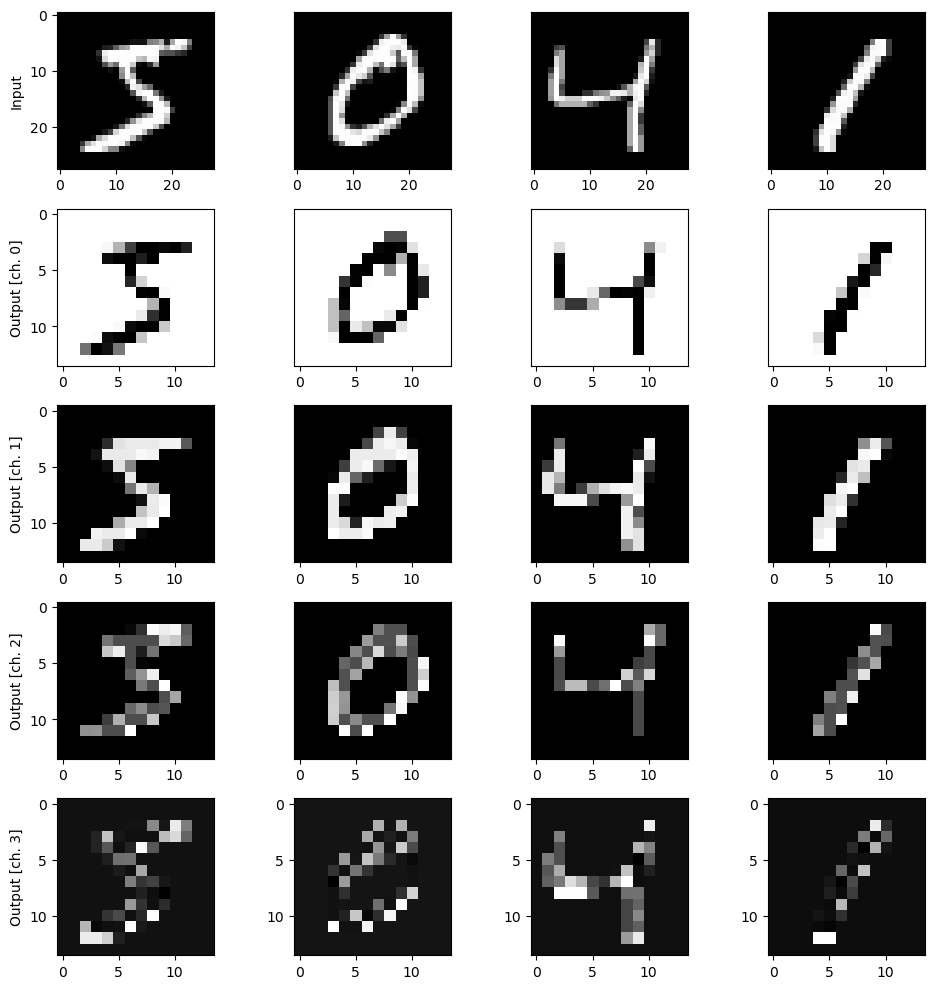

In [9]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()


# Hybrid quantum-classical model

#### Model Definition: 
Define a simple classical neural network model with one fully connected layer and a softmax activation function for classification. This model will be trained on the quantum-processed images.
#### Model Compilation: 
Compile the model using the Adam optimizer and sparse categorical cross-entropy loss function, which is suitable for multi-class classification problems like MNIST.

In [10]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model



# Training

#### Train and evaluate the hybrid quantum-classical model on the preprocessed dataset and compare its performance with a purely classical model trained on the original images.

#### Model Training: 
Train both the quantum-classical model (using quantum-processed images) and a purely classical model (using original images) on the MNIST dataset.
#### Performance Comparison: 
Compare the performance (in terms of accuracy and loss) of the quantum-enhanced model with the classical model to evaluate the impact of quantum preprocessing.

In [11]:
# Initialize and train the quantum-classical model

q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)


Epoch 1/30
13/13 - 1s - 114ms/step - accuracy: 0.0600 - loss: 2.7654 - val_accuracy: 0.2000 - val_loss: 2.3485
Epoch 2/30
13/13 - 0s - 7ms/step - accuracy: 0.3400 - loss: 2.0145 - val_accuracy: 0.3000 - val_loss: 2.1170
Epoch 3/30
13/13 - 0s - 9ms/step - accuracy: 0.5400 - loss: 1.6836 - val_accuracy: 0.4333 - val_loss: 1.9149
Epoch 4/30
13/13 - 0s - 9ms/step - accuracy: 0.6800 - loss: 1.3569 - val_accuracy: 0.5333 - val_loss: 1.7581
Epoch 5/30
13/13 - 0s - 10ms/step - accuracy: 0.8600 - loss: 1.1203 - val_accuracy: 0.5667 - val_loss: 1.6396
Epoch 6/30
13/13 - 0s - 8ms/step - accuracy: 0.9600 - loss: 0.9270 - val_accuracy: 0.6000 - val_loss: 1.5438
Epoch 7/30
13/13 - 0s - 8ms/step - accuracy: 0.9600 - loss: 0.7750 - val_accuracy: 0.6667 - val_loss: 1.4635
Epoch 8/30
13/13 - 0s - 9ms/step - accuracy: 0.9800 - loss: 0.6562 - val_accuracy: 0.7000 - val_loss: 1.3996
Epoch 9/30
13/13 - 0s - 9ms/step - accuracy: 0.9800 - loss: 0.5606 - val_accuracy: 0.7333 - val_loss: 1.3478
Epoch 10/30
13/1

# Classical model

In [12]:
#  Initialize and train a classical model for comparison

c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)


Epoch 1/30
13/13 - 1s - 92ms/step - accuracy: 0.1200 - loss: 2.2862 - val_accuracy: 0.0667 - val_loss: 2.2343
Epoch 2/30
13/13 - 0s - 9ms/step - accuracy: 0.3600 - loss: 1.9138 - val_accuracy: 0.3000 - val_loss: 2.0653
Epoch 3/30
13/13 - 0s - 12ms/step - accuracy: 0.6000 - loss: 1.6387 - val_accuracy: 0.4000 - val_loss: 1.9129
Epoch 4/30
13/13 - 0s - 12ms/step - accuracy: 0.7400 - loss: 1.4034 - val_accuracy: 0.4333 - val_loss: 1.7805
Epoch 5/30
13/13 - 0s - 9ms/step - accuracy: 0.8400 - loss: 1.2047 - val_accuracy: 0.5667 - val_loss: 1.6691
Epoch 6/30
13/13 - 0s - 10ms/step - accuracy: 0.9000 - loss: 1.0393 - val_accuracy: 0.6000 - val_loss: 1.5771
Epoch 7/30
13/13 - 0s - 8ms/step - accuracy: 0.9200 - loss: 0.9028 - val_accuracy: 0.6333 - val_loss: 1.5013
Epoch 8/30
13/13 - 0s - 9ms/step - accuracy: 0.9600 - loss: 0.7901 - val_accuracy: 0.6333 - val_loss: 1.4387
Epoch 9/30
13/13 - 0s - 8ms/step - accuracy: 0.9800 - loss: 0.6965 - val_accuracy: 0.7000 - val_loss: 1.3864
Epoch 10/30
13/

# Results¶

#### Performance Visualization: 
Plot the accuracy and loss for both the quantum-enhanced and classical models to visually compare their performance throughout the training process.
#### Result Analysis: 
Analyze the plotted results to determine if the quantum-enhanced model offers any benefits over the classical model in terms of learning efficiency or generalization.

C:\Users\Galane-Basha\AppData\Local\Temp\ipykernel_40312\4234478001.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


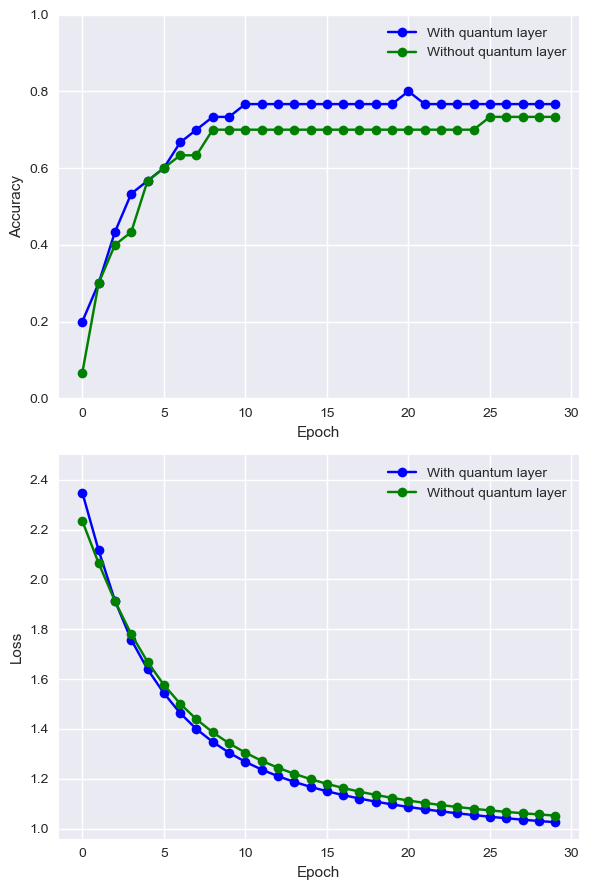

In [13]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()
